https://github.com/naity/image_tabular/blob/master/siim_isic_integrated_model.ipynb

# Imports

In [1]:
import pandas as pd
import torch
import tensorflow
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-09 17:33:44.007612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
# Image Data
df = pd.read_csv("../Data/final_dataset_cnn.csv")
df = df.dropna()
df[:5]

,views,thumbnail_link
0,17158579,n1WpP7iowLc
1,1014651,0dBIkQ4Mz1M
3,2095828,d380meD0W0M
4,33523622,2Vv-BfVoq4g
5,1309699,0yIWz1XEeyc


## Train - Test - Split

# Prepare Data

## Image Data

In [20]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1

In [18]:
import os

# The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device.
os.environ["YTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
dls = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('thumbnail_link', pref=Path('../Data/thumbnails/'), suff='.jpg'), 
    get_y=ColReader('views'),
    splitter=RandomSplitter(),
    batch_tfms=[*aug_transforms(size=(224,398)), 
                Normalize.from_stats(*imagenet_stats)]
).dataloaders(df)


Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
dls = block.dataloaders(df)

In [ ]:
dls.show_batch()

In [ ]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),RegressionBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

In [3]:
# load image data uwith fastai ImageDataLoaders

image_data = (ImageDataLoaders.from_df(df, path="../Data/", fn_col="thumbnail_link",
                               folder="thumbnails", suff=".jpg", label_col="views")
)

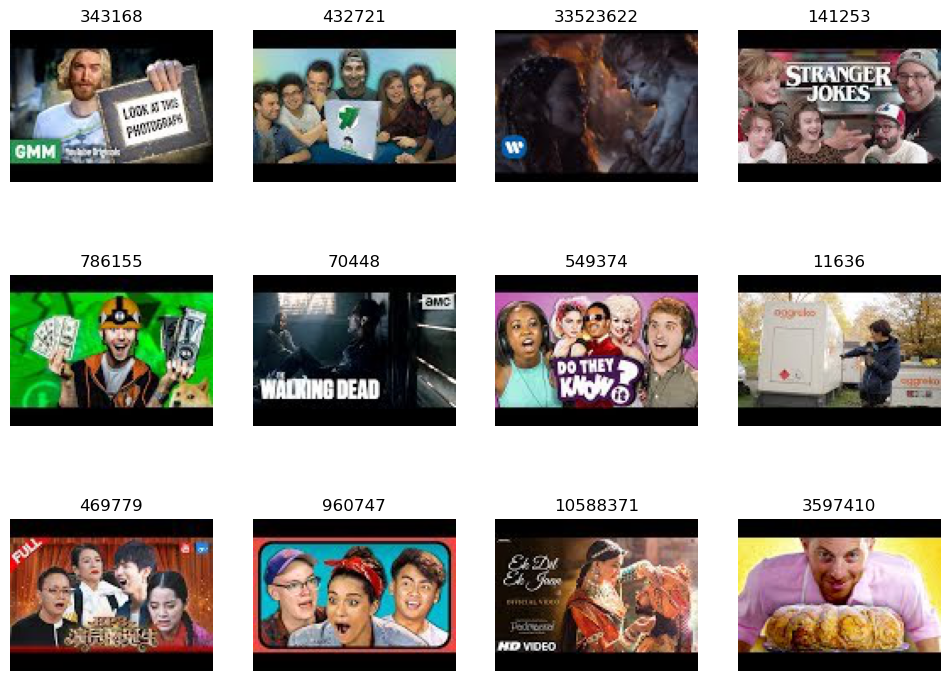

In [4]:

# show example images from tarining batch with label
image_data.train.show_batch(max_n = 12)

# Define CNN Model

In [8]:
from fastai.metrics import mae
from fastai.vision.learner import cnn_learner
from torchvision.models.resnet import resnet50

learn = cnn_learner(image_data, resnet50, loss_func=MSELossFlat(), y_range=(0,100), metrics=mae, ps=0.25)

In [14]:
learn.lr_find()

RuntimeError: The size of tensor a (4160) must match the size of tensor b (64) at non-singleton dimension 0

In [ ]:
# https://walkwithfastai.com/Scalar_Regression

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [93]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

AttributeError: databunch

# Create a Joint Model 

In [ ]:
# https://github.com/naity/image_tabular
# ! pip install image_tabular

integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)

In [ ]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [ ]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func)

In [ ]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

## Training

In [ ]:
# find learning rate to train the last layer group first 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
# train
learn.fit_one_cycle(10, 1e-4)

In [ ]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

## Prediction

In [ ]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)